<a id="import"></a>
# <center>Импортируем библиотеки</center>

In [49]:
import pandas as pd
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
import pydicom as dicom

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import time
from tqdm import tqdm
from sklearn.metrics import f1_score
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
print('All modules have been imported')

All modules have been imported


<a id="pc"></a>

In [3]:
def print_in_color(txt_msg,fore_tupple=(0,255,255),back_tupple=(100,100,100)):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

# example default print
msg='test of default colors'
print_in_color(msg)

test of default colors



<a id="makedf"></a>
# <center>Считывание исходных данных для train, test и valid</center>

In [4]:
def make_dataframes(train_dir,test_dir, val_dir):
    bad_images=[]
    dirlist=[train_dir, test_dir, val_dir]
    names=['train','test', 'valid']
    zipdir=zip(names, dirlist)
    for name,d in zipdir:
        filepaths=[]
        labels=[]
        classlist=sorted(os.listdir(d) )       
        for klass in classlist:
            # class names are very long so make psuedo names
            if 'adenocarcinoma' in klass:
                label='adenocarcinoma'
            elif 'large.cell.carcinoma' in klass:
                label='large.cell'
            elif 'squamous.cell' in klass:
                label='squamous.cell'
            elif 'others.cell' in klass:
                label='others.cell'
            else:
                label='normal'
            classpath=os.path.join(d, klass)           
            flist=sorted(os.listdir(classpath)) 
            desc=f'{name:6s}-{label:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                try:
                    img=cv2.imread(fpath)
                    shape=img.shape
                    filepaths.append(fpath)
                    labels.append(label)
                except:
                    print (fpath, ' is an invalid image file')
                    bad_images.append(fpath)
        Fseries=pd.Series(filepaths, name='filepaths')
        Lseries=pd.Series(labels, name='labels')
        df=pd.concat([Fseries, Lseries], axis=1) 
        if name =='valid':
            valid_df=df
        elif name == 'test':
            test_df=df
        else:
            train_df=df    
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio) 
    if len(bad_images)>0:
        print_in_color('Below is a list of invalid image files')
        for f in bad_images:
            print (f)
    return train_df, test_df, valid_df, classes, class_count

train_dir = r'C:/jupyter/1/Data/train/'
val_dir=r'C:/jupyter/1/Data/valid/'
test_dir=r'C:/jupyter/1/Data/test/'
train_df, test_df, valid_df, classes, class_count=make_dataframes(train_dir, test_dir, val_dir)


    

valid -squamous.cell            : 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 213.79files/s]


number of classes in processed dataset=  4
the maximum files in any class in train_df is  195   the minimum files in any class in train_df is  115
train_df length:  613   test_df length:  315   valid_df length:  72
average image height=  321   average image width=  448  aspect ratio h/w=  0.7165178571428571


In [5]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    classes=df[column].unique()
    class_count=len(classes)
    length=len(df)
    print ('dataframe initially is of length ',length, ' with ', class_count, ' classes')
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    classes=trimmed_df[column].unique()# return this in case some classes have less than min_samples
    class_count=len(classes) # return this in case some classes have less than min_samples
    length=len(trimmed_df)
    print ('the trimmed dataframe now is of length ',length, ' with ', class_count, ' classes')
    return trimmed_df, classes, class_count



In [6]:
def balance(df, n,column, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df[column].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby(column) # group by class
    for label in df[column].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=sorted(os.listdir(aug_dir))
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=sorted(os.listdir(classpath))    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')   
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=200
working_dir=r'./'
column='labels'
img_size=(300,440)
train_df=balance(train_df, n, column, working_dir, img_size)

Initial length of dataframe is  613
Found 195 validated image filenames.     for class         adenocarcinoma         creating   5   augmented images 
Found 115 validated image filenames.     for class           large.cell           creating  85   augmented images 
Found 148 validated image filenames.     for class             normal             creating  52   augmented images 
Found 155 validated image filenames.     for class         squamous.cell          creating  45   augmented images 
Total Augmented images created=  187
Length of augmented dataframe is now  800


<a id="generators"></a>
# <center>Create the train_gen, test_gen final_test_gen and valid_gen</center>

In [7]:
def make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator(horizontal_flip=True)    
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
    test_steps=int(length/test_batch_size)    
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col=ycol, target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps


In [8]:
batch_size=20
ycol='labels'
train_gen, test_gen, valid_gen, test_steps= make_gens(batch_size, ycol, train_df, test_df, valid_df, img_size)

Found 800 validated image filenames belonging to 4 classes.            for train generator 
Found 72 validated image filenames belonging to 4 classes.             for valid generator 
Found 315 validated image filenames belonging to 4 classes.            for test generator 
test batch size:  63   test steps:  5  number of classes :  4


<a id="show"></a>
# <center>Примеры изображений</center>

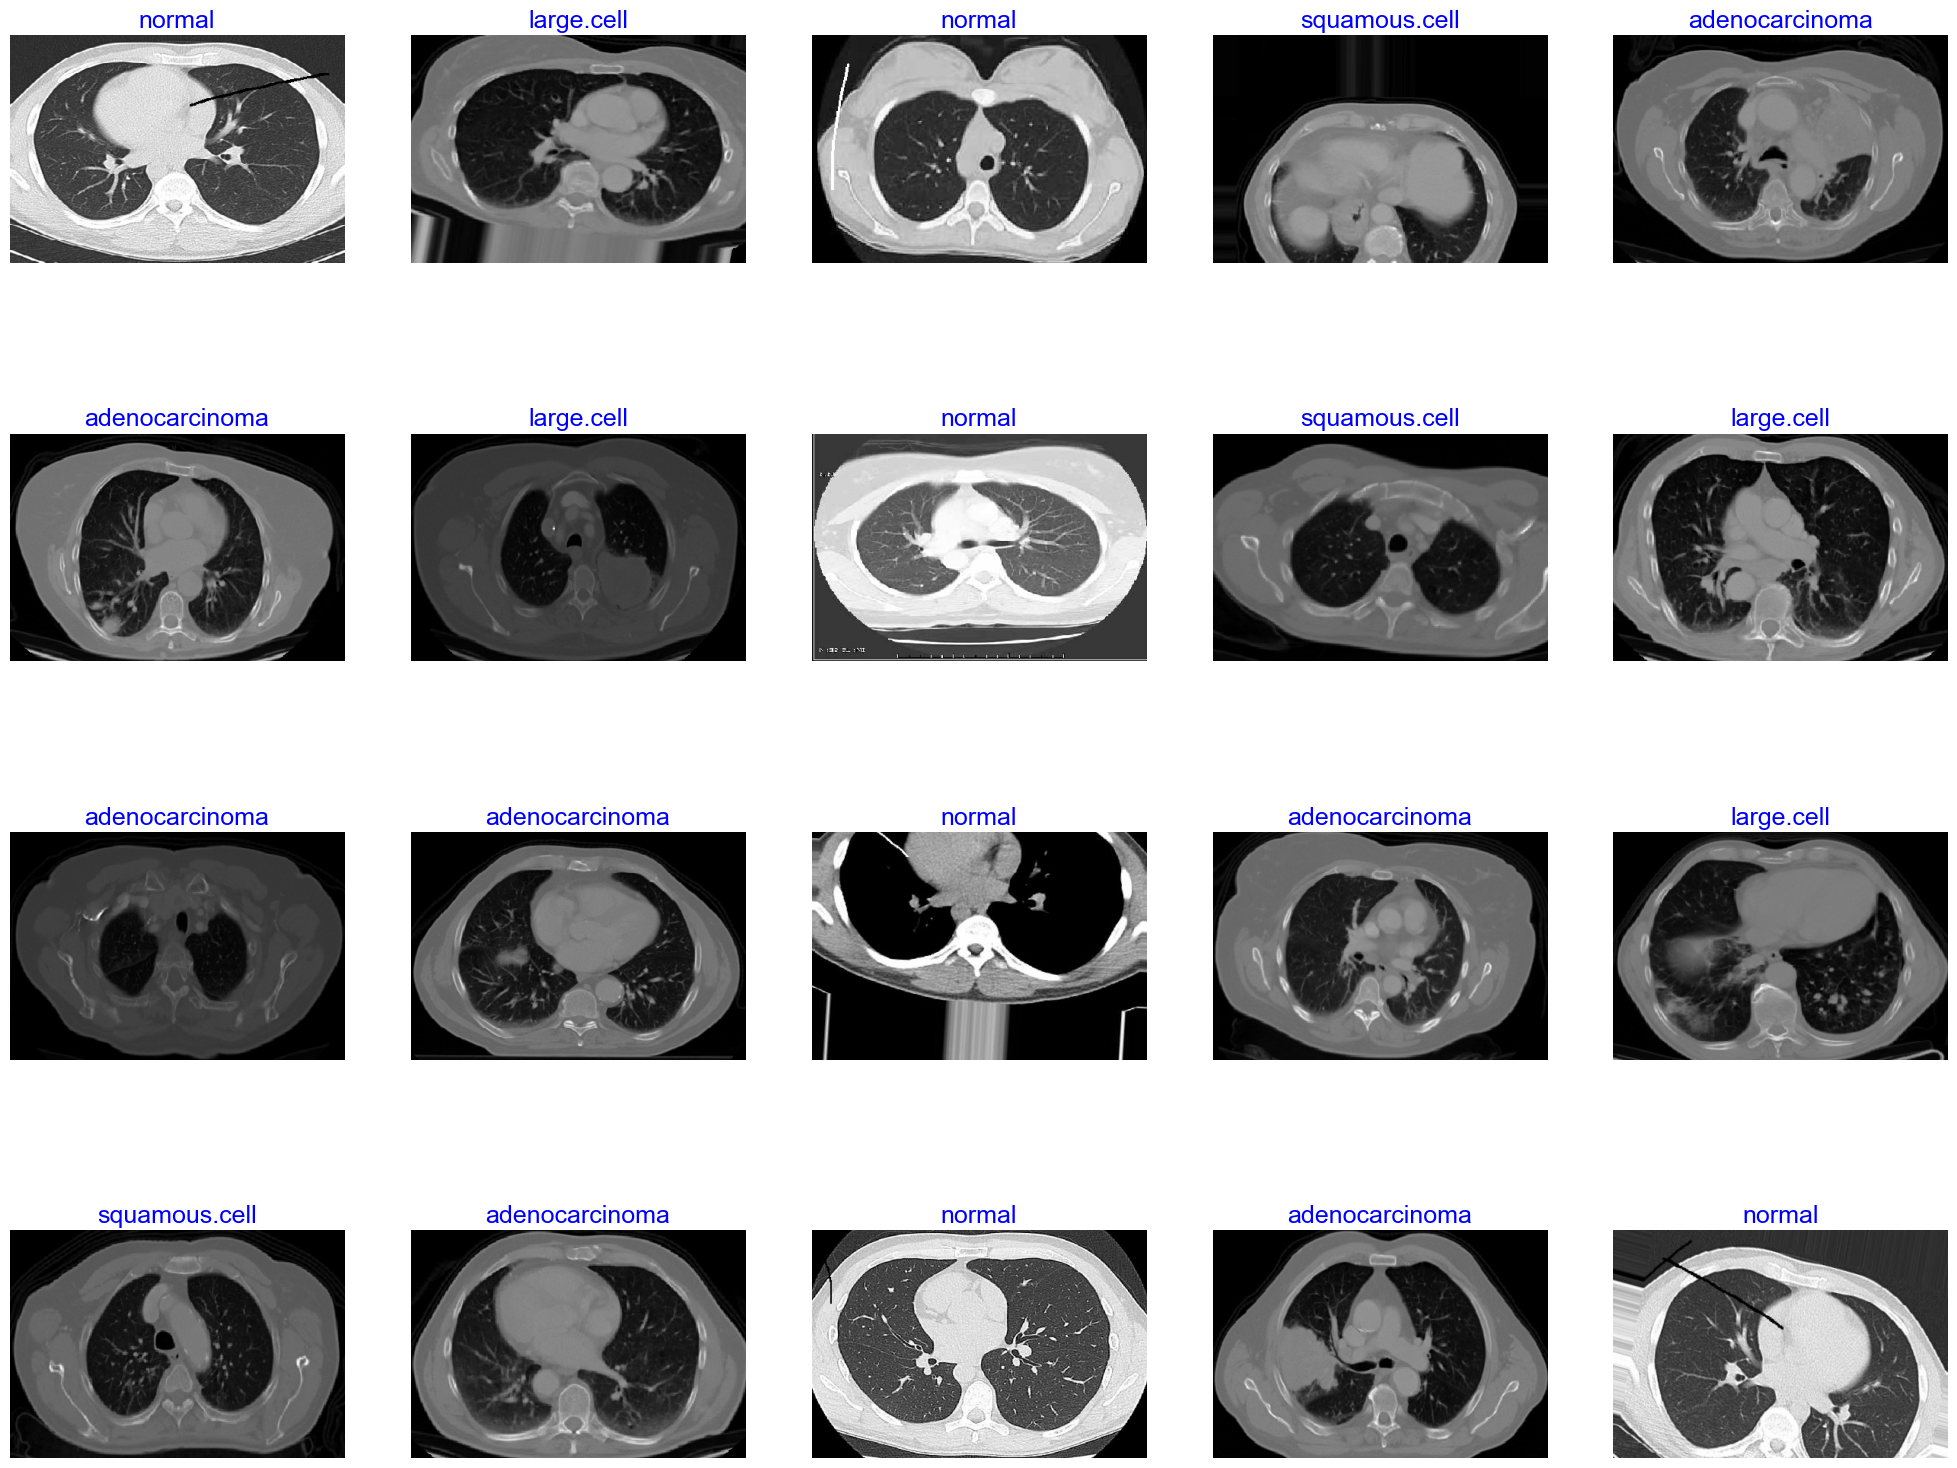

In [9]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

<a id="model"></a>
# <center>Строим модель на основе предобученной модели EfficientNetB3</center>

In [10]:
def make_model(img_size, lr, mod_num=3):  
    img_shape=(img_size[0], img_size[1], 3)
    if mod_num == 0:
        base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B0 model'
    elif mod_num == 3:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'
    elif mod_num == 5:
        base_model=tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B5 model'
        
    else:
        base_model=tf.keras.applications.efficientnet.EfficientNetB7(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
        msg='Created EfficientNet B7 model'   
   
    base_model.trainable=True
    x=base_model.output
    x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.4, seed=123)(x)       
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print_in_color(msg)
    return model

lr=.001
model=make_model(img_size, lr) # using B3 model by default

Created EfficientNet B3 model with initial learning rate set to 0.001



In [11]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print_in_color(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print_in_color(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print_in_color(msg, (0,255,0))
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print_in_color(msg, (0,255,255))
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print_in_color(msg, (0,255,0)) # green foreground
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print_in_color(msg, (255,255,0)) # yellow foreground
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print_in_color(msg) # cyan foreground
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print_in_color(msg) # cyan foreground
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print_in_color(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print_in_color(msg) # cyan foreground
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print_in_color(msg) # cyan foreground
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print_in_color(msg) # cyan foreground
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print_in_color(msg) # cyan foreground

<a id="callbacks"></a>
# <center>Настройки 

In [12]:
epochs=40
ask_epoch=10
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

<a id="train"></a>
# <center>Обучение модели

In [13]:

history=model.fit(x=train_gen,   epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 10 then you will be asked to

enter H to halt training or enter an integer for how many more epochs to run then be asked again

learning rate will be automatically adjusted during training

Epoch 1/40
40/40 [==============================] - ETA: 0s - loss: 8.5766 - accuracy: 0.6250 
 validation loss of  9.9707 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights

40/40 [==============================] - 629s 15s/step - loss: 8.5766 - accuracy: 0.6250 - val_loss: 9.9707 - val_accuracy: 0.5278
Epoch 2/40
40/40 [==============================] - ETA: 0s - loss: 7.1626 - accuracy: 0.8462 
 validation loss of  8.1711 is 18.0489 % below lowest loss, saving weights from epoch 2   as best weights

40/40 [==============================] - 588s 15s/step - loss: 7.1626 - accuracy: 0.8462 - val_loss: 8.1711 - val_accuracy: 0.5278
Epoch 3/40
40/40 [==============================] - ETA: 0s - loss: 6.3077 - accuracy: 0.9187 
 validation los

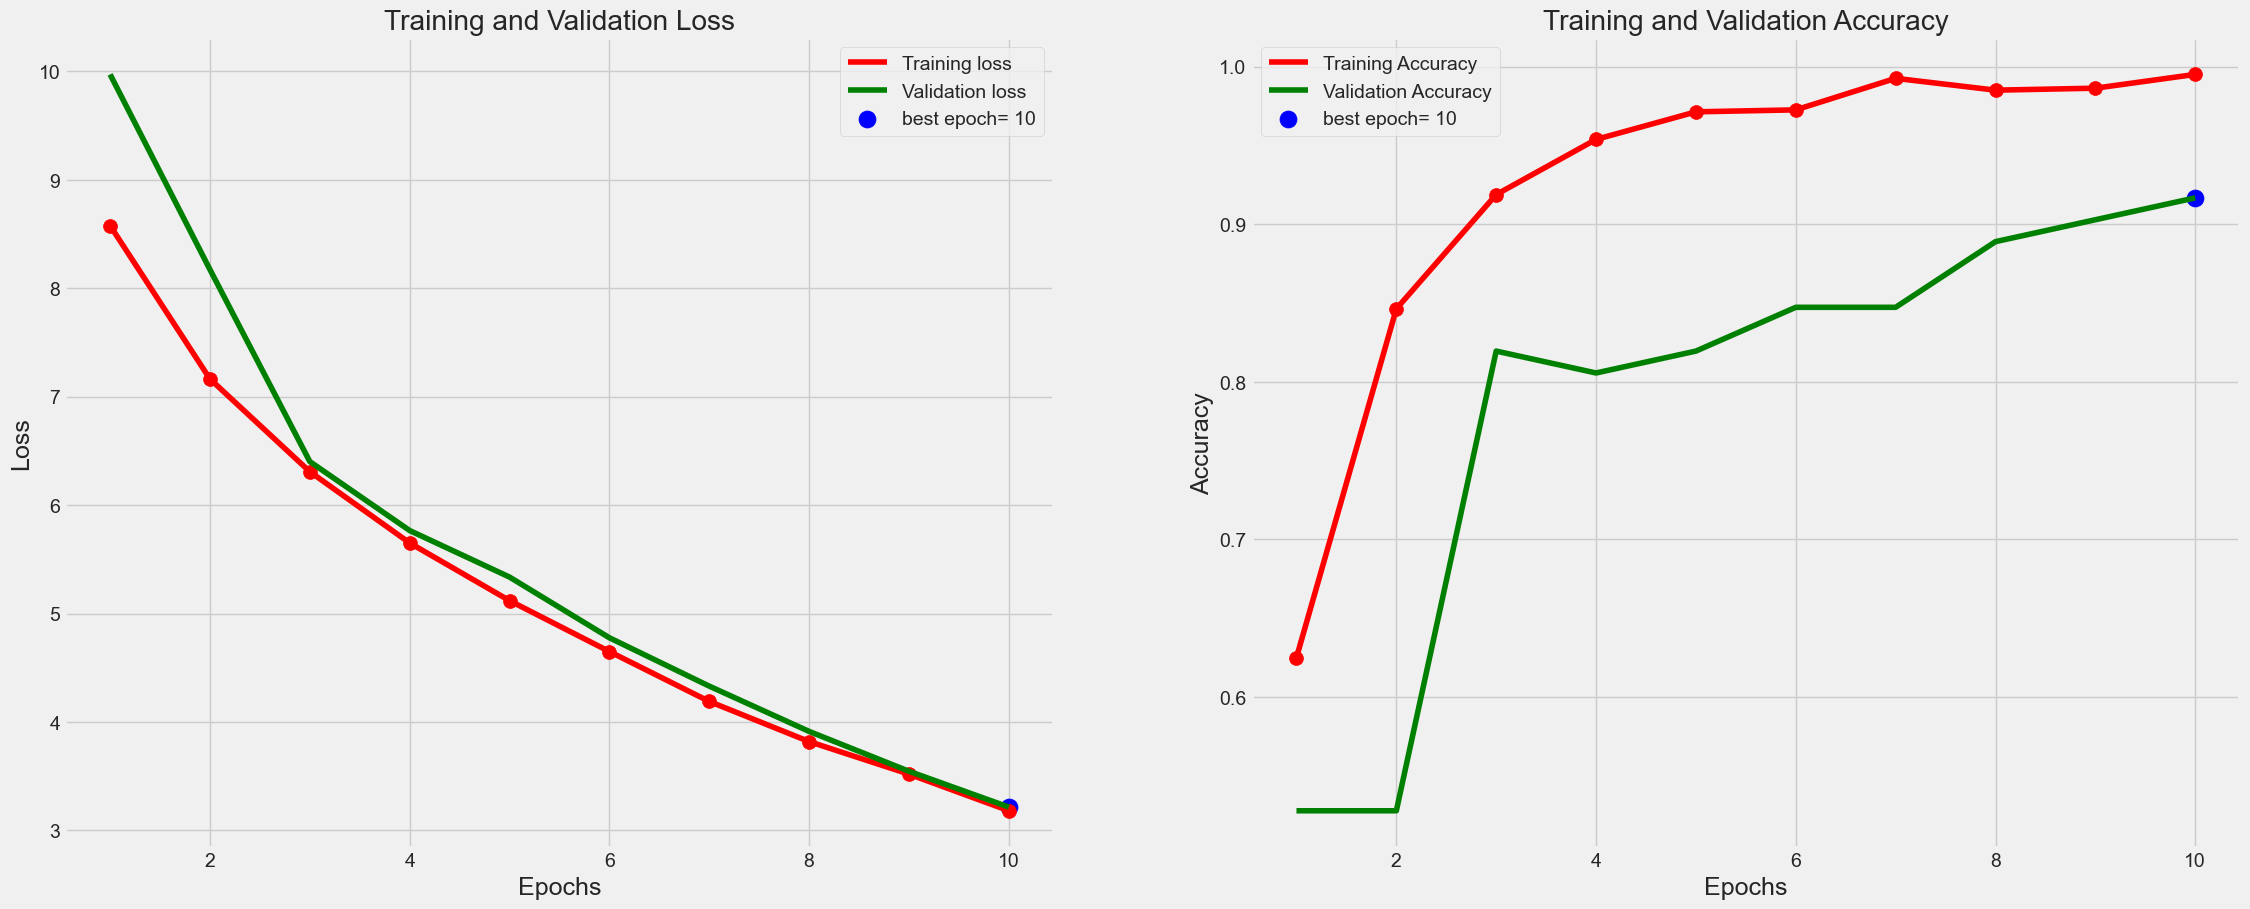

In [14]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')    
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
    
tr_plot(history,0)

<a id="result"></a>
# <center>Прогноз на тестовом наборе</a>

5/5 [==============================] - 30s 6s/step
<class 'numpy.ndarray'>
there were 24 errors in 315 tests for an accuracy of  92.38



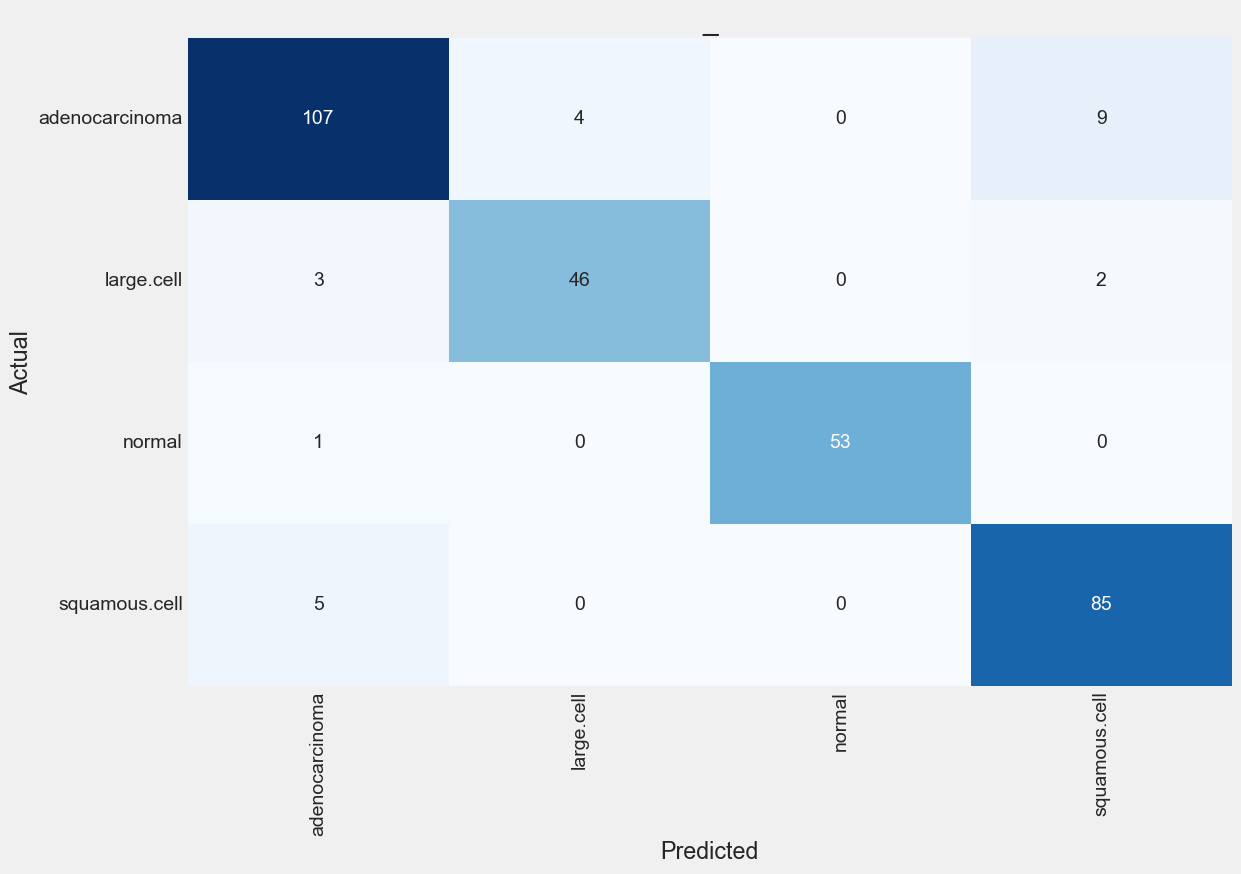

Classification Report:
----------------------
                 precision    recall  f1-score   support

adenocarcinoma     0.9224    0.8917    0.9068       120
    large.cell     0.9200    0.9020    0.9109        51
        normal     1.0000    0.9815    0.9907        54
 squamous.cell     0.8854    0.9444    0.9140        90

      accuracy                         0.9238       315
     macro avg     0.9320    0.9299    0.9306       315
  weighted avg     0.9248    0.9238    0.9239       315



In [15]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    print(type(preds))
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]
            error_list.append(file)
            error_class=classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("_")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, error_pred_list, f1score

errors, tests, error_list, error_pred_list, f1score =predictor(test_gen)

In [16]:
def print_errors(error_list):
    if len(error_list) == 0:
        print_in_color('There were no errors in predicting the test set')
    else:
        if len(error_list)<50:
            print ('Below is a list of test files that were miss classified \n')
            print ('{0:^30s}{1:^30s}'.format('Test File', ' Predicted as'))            
            for i in range(len(error_list)):
                fpath=error_list[i]        
                split=fpath.split('/')        
                f=split[4]+ '-' + split[5]
                print(f'{f:^30s}{error_pred_list[i]:^30s}')

In [17]:
print_errors(error_list)

Below is a list of test files that were miss classified 

          Test File                    Predicted as         
test-adenocarcinoma\000115 (4).png          large.cell          
test-adenocarcinoma\000117 (4).png        squamous.cell         
test-adenocarcinoma\000122 (4).png        squamous.cell         
test-adenocarcinoma\000124 (6).png        squamous.cell         
test-adenocarcinoma\000125 (2).png        squamous.cell         
test-adenocarcinoma\000130 (6).png        squamous.cell         
test-adenocarcinoma\000143 (6).png        squamous.cell         
test-adenocarcinoma\000158 (3).png          large.cell          
test-adenocarcinoma\000160 (6).png        squamous.cell         
test-adenocarcinoma\000166 (3).png          large.cell          
test-adenocarcinoma\000167 (3).png          large.cell          
test-adenocarcinoma\000174 (4).png        squamous.cell         
test-adenocarcinoma\000177.png        squamous.cell         
test-large.cell.carcinoma\000108.png    

<a id="save"></a>
# <center>Сохраняем модель</a>

In [18]:
def save_model(subject, classes, img_size, f1score, working_dir):
    name=subject + '---' + str(len(classes)) + '-(' + str(img_size[0]) + ' X ' + str(img_size[1]) + ')'
    save_id=f'{name}-{f1score:5.2f}.h5'
    model_save_loc=os.path.join(working_dir, save_id)
    model.save(model_save_loc)
    msg= f'model was saved as {model_save_loc}'
    print_in_color(msg, (0,255,255), (100,100,100)) # cyan foreground

In [19]:
tf.keras.model.save('chest_scans_.h5')

AttributeError: module 'tensorflow.keras' has no attribute 'model'

In [ ]:
working_dir=r'./'
subject='chest scans'
save_model(subject, classes, img_size, f1score, working_dir)

<a id="result"></a>

# Загружаем файл модели</a>

In [ ]:
model_new = tf.keras.models.load_model("chest scans-4-(300 X 440)-84.47.h5")

In [ ]:
model = keras.models.load_model('chest_scans.h5')

<a id="result"></a>

# Преобразуем DICOM файл в массив фото</a>

<a id="result"></a>

# Показываем слои в которых обнаружены нарушения</a>

In [ ]:
dicom_dir = r'C:/jupyter/1/Data/dicom/'
dicom_dir = r'C:\Users\Zugrik\Downloads\Lola11-Легкие\lola11-01'

In [105]: from pydicom.data import get_testdata_files

# read a sample image
In [106]: filename = get_testdata_files('MR_small.dcm')[0]
     ...: ds = pydicom.dcmread(filename)

In [107]: data = ds.pixel_array

In [108]: type(data)
Out[108]: numpy.ndarray

In [109]: data.shape
Out[109]: (64, 64)

In [111]: from skimage.transform import resize
In [114]: IMG_PX_SIZE = 32

# resize to new size
In [115]: resized_img = resize(data, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)

In [116]: resized_img.shape
Out[116]: (32, 32)

In [58]:
dicom_dir = r'C:\Users\Zugrik\Downloads\Lola11-Легкие\lola11-01'
pic=os.listdir(dicom_dir)
class_names=list(test_gen.class_indices.keys())


for i in pic:
    image_path = fr'{dicom_dir}\{i}'
    ds = dicom.dcmread(image_path)
    pixel_array_numpy = ds.pixel_array
        
    prediction = model.predict(img_array)
    
    if (class_names[np.argmax(prediction)]) == 'normal':
        print('1')
    else:
        #print('0')
        print("This image {} most likely belongs to {} with a {:.2f} percent confidence."
              .format(i, class_names[np.argmax(prediction)], 100 * np.max(prediction))
              )
    

1/1 [==============================] - 0s 136ms/step
1
1/1 [==============================] - 0s 146ms/step
1
1/1 [==============================] - 0s 147ms/step
1
1/1 [==============================] - 0s 137ms/step
1
1/1 [==============================] - 0s 136ms/step
1
1/1 [==============================] - 0s 152ms/step
1
1/1 [==============================] - 0s 128ms/step
1
1/1 [==============================] - 0s 150ms/step
1
1/1 [==============================] - 0s 147ms/step
1
1/1 [==============================] - 0s 148ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 182ms/step
1
1/1 [==============================] - 0s 145ms/step
1
1/1 [==============================] - 0s 138ms/step
1
1/1 [==============================] - 0s 142ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 150ms/step
1
1/1 [==============================] - 0s 151ms/step
1
1/1 [=====

1
1/1 [==============================] - 0s 146ms/step
1
1/1 [==============================] - 0s 137ms/step
1
1/1 [==============================] - 0s 145ms/step
1
1/1 [==============================] - 0s 153ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 177ms/step
1
1/1 [==============================] - 0s 181ms/step
1
1/1 [==============================] - 0s 160ms/step
1
1/1 [==============================] - 0s 139ms/step
1
1/1 [==============================] - 0s 133ms/step
1
1/1 [==============================] - 0s 145ms/step
1
1/1 [==============================] - 0s 134ms/step
1
1/1 [==============================] - 0s 138ms/step
1
1/1 [==============================] - 0s 143ms/step
1
1/1 [==============================] - 0s 137ms/step
1
1/1 [==============================] - 0s 158ms/step
1
1/1 [==============================] - 0s 154ms/step
1
1/1 [==============================] - 0s 180ms/step
1
1/1 [===

1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 157ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 139ms/step
1
1/1 [==============================] - 0s 154ms/step
1
1/1 [==============================] - 0s 160ms/step
1
1/1 [==============================] - 0s 156ms/step
1
1/1 [==============================] - 0s 153ms/step
1
1/1 [==============================] - 0s 140ms/step
1
1/1 [==============================] - 0s 161ms/step
1
1/1 [==============================] - 0s 153ms/step
1
1/1 [==============================] - 0s 139ms/step
1
1/1 [==============================] - 0s 146ms/step
1
1/1 [==============================] - 0s 153ms/step
1
1/1 [==============================] - 0s 148ms/step
1
1/1 [==============================] - 0s 151ms/step
1
1/1 [==============================] - 0s 144ms/step
1
1/1 [==============================] - 0s 140ms/step
1
1/1 [===

1
1/1 [==============================] - 0s 151ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 145ms/step
1
1/1 [==============================] - 0s 142ms/step
1
1/1 [==============================] - 0s 158ms/step
1
1/1 [==============================] - 0s 153ms/step
1
1/1 [==============================] - 0s 157ms/step
1
1/1 [==============================] - 0s 155ms/step
1
1/1 [==============================] - 0s 159ms/step
1
1/1 [==============================] - 0s 149ms/step
1
1/1 [==============================] - 0s 162ms/step
1
1/1 [==============================] - 0s 150ms/step
1
1/1 [==============================] - 0s 147ms/step
1
1/1 [==============================] - 0s 148ms/step
1
1/1 [==============================] - 0s 160ms/step
1
1/1 [==============================] - 0s 154ms/step
1
1/1 [==============================] - 0s 145ms/step
1


In [59]:
dicom_dir = r'C:\jupyter\1\Data\dicom\CT_TUBERCULOSIS_anon\1.2.643.5.1.13.13.12.2.77.8252.07011304111203070701030403031010\1.2.643.5.1.13.13.12.2.77.8252.02121010060208081005130614081409'
pic=os.listdir(dicom_dir)
class_names=list(test_gen.class_indices.keys())


for i in pic:
    image_path = fr'{dicom_dir}\{i}'
    ds = dicom.dcmread(image_path)
    pixel_array_numpy = ds.pixel_array
    #print(pixel_array_numpy.shape)
    resized_img = resize(pixel_array_numpy, (300, 430, 3), anti_aliasing=True)    
    #print(resized_img.shape)
    prediction = model.predict(resized_img)
    print(class_names[np.argmax(prediction)])
    if (class_names[np.argmax(prediction)]) == 'normal':
        print('1')
    else:
        #print('0')
        print("This image {} most likely belongs to {} with a {:.2f} percent confidence."
              .format(i, class_names[np.argmax(prediction)], 100 * np.max(prediction))
              )

10/10 [==============================] - 0s 32ms/step


IndexError: list index out of range

ValueError: in user code:

    File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "C:\Program Files\Anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Program Files\Anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 300, 440, 3), found shape=(32, 512)


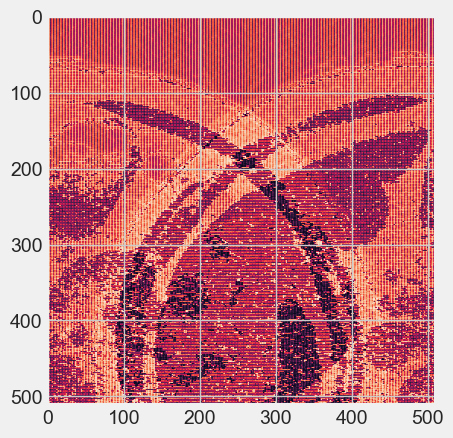

In [44]:
dicom_dir = r'C:\Users\Zugrik\Downloads\Lola11-Легкие\lola11-01'
pic=os.listdir(dicom_dir)
class_names=list(test_gen.class_indices.keys())


for i in pic:
    image_path = fr'{dicom_dir}\{i}'
    ds = dicom.dcmread(image_path)
    pixel_array_numpy = ds.pixel_array
    plt.imshow(ds.pixel_array)
    #print(image_path)
    
    model.predict(pixel_array_numpy)
    
    
    #prediction = model.predict(pixel_array_numpy, 300, 440, 3)

    #print("This image {} most likely belongs to {} with a {:.2f} percent confidence."
    #      .format(i, class_names[np.argmax(prediction)], 100 * np.max(prediction))
    #     )
    
    #print(class_names[np.argmax(prediction)])
    
    #if (class_names[np.argmax(prediction)]) == 'normal':
    #    print('1')
    #else:
        #print('0')
    #    print("This image {} most likely belongs to {} with a {:.2f} percent confidence."
    #          .format(i, class_names[np.argmax(prediction)], 100 * np.max(prediction))
    #          )

In [25]:
image_path = r'C:\Users\Zugrik\Downloads\Lola11-Легкие\lola11-01\025.dcm'
ds = dicom.dcmread(image_path)


pixel_array_numpy = ds.pixel_array

image_format = '.jpg' # or '.png'
image_path = image_path.replace('.dcm', image_format)

cv2.imwrite(image_path, pixel_array_numpy)

False

<a id="result"></a>

# Проверяем модель на случайных картинках</a>

img = load_img('tuberculez_1.jpg')
img_array = img_to_array(img)
img_array.resize(300, 440, 3)
img_expended = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_expended)[0][0]
print(prediction)

In [66]:
img_path = "4K-Spongebob-Best-Wallpaper.jpg"

#   tuberculez_2.jpg
#   4K-Spongebob-Best-Wallpaper.jpg

class_names=list(test_gen.class_indices.keys())

img = tf.keras.utils.load_img(img_path, target_size=(300, 440, 3))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model.predict(img_array)

print( 
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(prediction)], 100 * np.max(prediction))
      
)

cv2.imread(image_path)

1/1 [==============================] - 0s 161ms/step
This image most likely belongs to normal with a 50.64 percent confidence.
